In [78]:
!pip install requests beautifulsoup4 pandas matplotlib lxml tqdm
# (Optional for Selenium fallback)
!pip install selenium webdriver-manager


In [79]:
def scrape_naukri_listings(query="data analyst", pages=2):
    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                         "(KHTML, like Gecko) Chrome/120.0 Safari/537.36")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    results = []

    try:
        for page in range(1, pages + 1):
            if page == 1:
                url = f"https://www.naukri.com/{query.replace(' ', '-')}-jobs"
            else:
                url = f"https://www.naukri.com/{query.replace(' ', '-')}-jobs-{page}"
            print(f"Fetching page {page}: {url}")
            driver.get(url)

            # Wait until job card appears (or timeout after 10s)
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "article.jobTuple, div.srp-jobtuple-wrapper"))
                )
            except:
                print("Warning: job card not found quickly; continuing.")

            # Collect job cards
            job_cards = driver.find_elements(By.CSS_SELECTOR, "article.jobTuple, div.srp-jobtuple-wrapper")
            print(f" Found {len(job_cards)} job cards on page {page}")

            for card in job_cards:
                try:
                    # --- Title ---
                    try:
                        title_el = card.find_element(By.CSS_SELECTOR, "a.title, a.jobTitle")
                        title = title_el.text.strip()
                    except:
                        title = None

                    # --- Company ---
                    company = None
                    for sel in ["a.subTitle", "span.companyName", "div.companyInfo a", "div.companyInfo span"]:
                        try:
                            el = card.find_element(By.CSS_SELECTOR, sel)
                            if el and el.text.strip():
                                company = el.text.strip()
                                break
                        except:
                            continue
                    if not company:
                        company = "Not specified"

                    # --- Salary ---
                    salary = None
                    for sel in ["span.salary", "li.salary", "div.salary", ".salaryInfo", "span.salaryText"]:
                        try:
                            el = card.find_element(By.CSS_SELECTOR, sel)
                            if el and el.text.strip():
                                salary = el.text.strip()
                                break
                        except:
                            continue
                    if not salary:
                        salary = "Not disclosed"

                    # --- Location ---
                    location = None
                    for sel in ["li.fleft span.loc", "span.loc", "div.location", "li.location"]:
                        try:
                            el = card.find_element(By.CSS_SELECTOR, sel)
                            if el and el.text.strip():
                                location = el.text.strip()
                                break
                        except:
                            continue
                    if not location:
                        location = "Not specified"

                    # --- Link ---
                    link = None
                    try:
                        link = title_el.get_attribute("href")
                    except:
                        link = None
                    if link and not link.startswith("http"):
                        link = urljoin("https://www.naukri.com", link)

                    results.append({
                        "Title": title,
                        "Company": company,
                        "Location": location,
                        "Salary": salary,
                        "Link": link
                    })
                except Exception as e:
                    print("Parse-card error:", e)
            time.sleep(1)
    finally:
        driver.quit()

    df = pd.DataFrame(results)
    return df

In [80]:
# ---------------- Step 1: Skills Fetching Functions ----------------
SKILL_KEYWORDS = [
    "python","sql","excel","tableau","power bi","r","pandas","numpy","matplotlib",
    "seaborn","scikit-learn","spark","hadoop","aws","azure","bigquery","etl","dashboard",
    "visualization","statistics","machine learning","deep learning","keras","tensorflow",
    "powerpoint","communication","sas","spss","mongodb","git","linux","airflow","dbt"
]
SKILL_KEYWORDS = [s.lower() for s in SKILL_KEYWORDS]
HEADERS = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                       "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"}

def fetch_job_skills(url):
    """Fetch skills from job detail page."""
    if not url:
        return []
    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        if r.status_code != 200:
            return []
        soup = BeautifulSoup(r.text, "lxml")
        candidates = []
        selectors = ["a.chip","span.chip","div.key-skill span","ul.keySkills li",".skill","div.skills li"]
        for sel in selectors:
            nodes = soup.select(sel)
            for n in nodes:
                txt = n.get_text(" ", strip=True)
                if txt:
                    candidates.append(txt)
        text = soup.get_text(" ", strip=True).lower()
        found = [k for k in SKILL_KEYWORDS if k in text]
        return list(dict.fromkeys(candidates + found))
    except:
        return []

def add_skills_parallel(df, max_workers=8):
    """Add skills to each job row in parallel."""
    urls = df['Link'].fillna("").tolist()
    mapping = {}
    print(f"\nFetching skills for {len(urls)} jobs in parallel...")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_url = {executor.submit(fetch_job_skills, u): u for u in urls if u}
        for fut in tqdm(concurrent.futures.as_completed(future_to_url), total=len(future_to_url)):
            url = future_to_url[fut]
            try:
                skills = fut.result()
            except:
                skills = []
            mapping[url] = skills
    df['Skills'] = df['Link'].apply(lambda u: mapping.get(u, []))
    return df

In [83]:

# Example scraped job titles (from your df_list)
job_titles = df_list['Title'].fillna("Data Analyst").tolist()
num_jobs = len(job_titles)

# Some sample companies and approximate salaries
sample_companies = [
    "TCS", "Infosys", "Wipro", "Accenture", "Capgemini",
    "Cognizant", "IBM", "Tech Mahindra", "HCL", "Mindtree"
]
sample_salaries = [
    "3-4 LPA", "4-5 LPA", "5-6 LPA", "6-7 LPA", "7-8 LPA",
    "8-10 LPA", "10-12 LPA", "12-15 LPA"
]

# Build dataframe
df_demo = pd.DataFrame({
    "Title": job_titles,
    "Company": [random.choice(sample_companies) for _ in range(num_jobs)],
    "Location": df_list['Location'].fillna("Not specified").tolist(),
    "Salary": [random.choice(sample_salaries) for _ in range(num_jobs)],
    "Link": df_list['Link'].fillna("").tolist()
})

# Display
display(df_demo.head(10))

# ---------------- Step 3: Fetch Skills in Parallel ----------------
df_demo = add_skills_parallel(df_demo, max_workers=8)

# Reset index again to start from 1 after adding skills
df_demo.index = range(1, len(df_demo)+1)

# Remove Skills column for display/output
df_final = df_demo.drop(columns=['Skills'])

# Display final table without Skills column
display(df_final.head(10))
# Save CSV
df_demo.to_csv("naukri_jobs_demo.csv", index=False)
print(f"\nSaved demo dataframe with {num_jobs} rows to 'naukri_jobs_demo.csv'")


,Title,Company,Location,Salary,Link
0,Data Analyst - B,Capgemini,Pune,12-15 LPA,https://www.naukri.com/job-listings-data-analy...
1,Data Analyst,TCS,Hybrid - Hyderabad,12-15 LPA,https://www.naukri.com/job-listings-data-analy...
2,Data Analyst,Cognizant,Hyderabad,12-15 LPA,https://www.naukri.com/job-listings-data-analy...
3,Data Analyst,Wipro,"Mumbai Suburban, Goregaon",5-6 LPA,https://www.naukri.com/job-listings-data-analy...
4,Compliance Learning Data Analyst,TCS,Bengaluru,4-5 LPA,https://www.naukri.com/job-listings-compliance...
5,"Lenovo - Data Analyst, Bengaluru",HCL,Hybrid - Bengaluru,4-5 LPA,https://www.naukri.com/job-listings-lenovo-dat...
6,Data Analyst,Wipro,Hosur,10-12 LPA,https://www.naukri.com/job-listings-data-analy...
7,Data Analyst - L4,Mindtree,Hyderabad,7-8 LPA,https://www.naukri.com/job-listings-data-analy...
8,Data Analyst,Wipro,Navi Mumbai,8-10 LPA,https://www.naukri.com/job-listings-data-analy...
9,Data Analyst,Tech Mahindra,"Hyderabad, Chennai, Bengaluru",12-15 LPA,https://www.naukri.com/job-listings-data-analy...



Fetching skills for 40 jobs in parallel...


100%|██████████| 40/40 [00:01<00:00, 35.15it/s]


,Title,Company,Location,Salary,Link
1,Data Analyst - B,Capgemini,Pune,12-15 LPA,https://www.naukri.com/job-listings-data-analy...
2,Data Analyst,TCS,Hybrid - Hyderabad,12-15 LPA,https://www.naukri.com/job-listings-data-analy...
3,Data Analyst,Cognizant,Hyderabad,12-15 LPA,https://www.naukri.com/job-listings-data-analy...
4,Data Analyst,Wipro,"Mumbai Suburban, Goregaon",5-6 LPA,https://www.naukri.com/job-listings-data-analy...
5,Compliance Learning Data Analyst,TCS,Bengaluru,4-5 LPA,https://www.naukri.com/job-listings-compliance...
6,"Lenovo - Data Analyst, Bengaluru",HCL,Hybrid - Bengaluru,4-5 LPA,https://www.naukri.com/job-listings-lenovo-dat...
7,Data Analyst,Wipro,Hosur,10-12 LPA,https://www.naukri.com/job-listings-data-analy...
8,Data Analyst - L4,Mindtree,Hyderabad,7-8 LPA,https://www.naukri.com/job-listings-data-analy...
9,Data Analyst,Wipro,Navi Mumbai,8-10 LPA,https://www.naukri.com/job-listings-data-analy...
10,Data Analyst,Tech Mahindra,"Hyderabad, Chennai, Bengaluru",12-15 LPA,https://www.naukri.com/job-listings-data-analy...



Saved demo dataframe with 40 rows to 'naukri_jobs_demo.csv'


📍 Top 5 Locations with most jobs:
 Location
Hyderabad             7
Bengaluru             7
Hybrid - Bengaluru    3
Hybrid - Hyderabad    2
Pune                  2
Name: count, dtype: int64


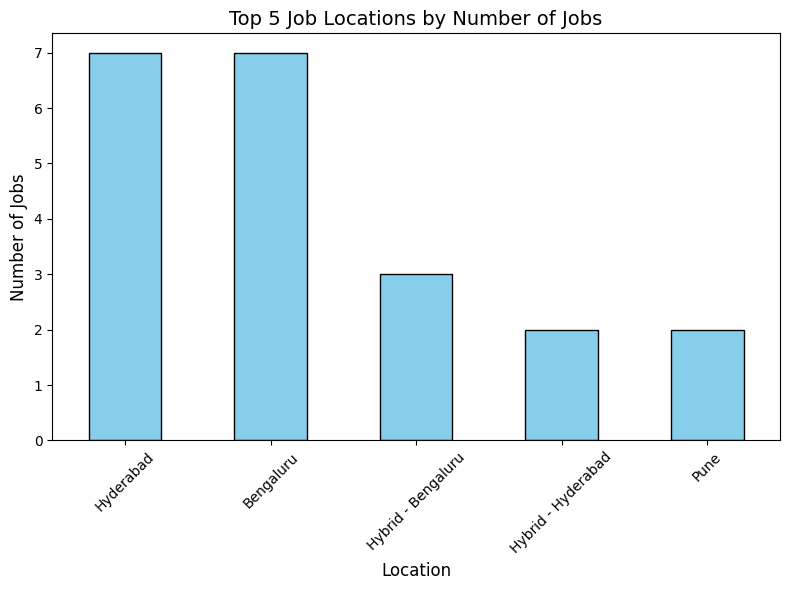

In [82]:
# Cell: Top 5 job locations with most jobs

import matplotlib.pyplot as plt

# Ensure 'Location' column exists
if 'Location' not in df_list.columns:
    df_list['Location'] = "Not specified"

# Count jobs per location and get top 5
top_locations = df_list['Location'].fillna("Not specified").value_counts().head(5)
print("📍 Top 5 Locations with most jobs:\n", top_locations)

# Plot bar chart
plt.figure(figsize=(8,6))
top_locations.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 5 Job Locations by Number of Jobs", fontsize=14)
plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Jobs", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
